# Vanilla RNN Implementation

In [1]:
import numpy as np
import datetime

Every operation (including matrix multiplication) is a separate layer and returns gradient

In [2]:
class Sigmoid():
    def __call__(self, x):
        return self.sigmoid(x)
    
    def sigmoid(self, x):
        self.o = 1 / (1 + np.exp(-x))
        # print("Hello", self.o)
        self.x = x #remembers its inputs for backpropagation
        return self.o
    
    def backward(self, dz):
        return dz * self.o * (1 - self.o)

class Relu():
    def __call__(self, x):
        return self.relu(x)
    
    def relu(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz):
        return dz * (self.x > 0)

class Tanh():
    # @TODO: Implement memory as done in sigmoid
    def __call__(self, x):
        return self.tanh(x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def backward(self, x):
        return 1 - np.tanh(x)**2

In [3]:
class Add():
    def __call__(self, x, y):
        return self.forward(x, y)
    
    def forward(self, x, y):
        self.o = x + y
        self.x = x
        self.y = y
        return self.o
    
    def backward(self, dz):
        self.dx = dz * np.ones_like(self.x)
        self.dy = dz * np.ones_like(self.y)
        return self.dx, self.dy

class Multiply():
    def __call__(self, W, x):
        return self.forward(W, x)
    
    def forward(self, W, x):
        self.o = W @ x
        self.W = W
        self.x = x
        return self.o
    
    def backward(self, dz):
        # print(dz.shape, self.x.shape)
        self.dW = dz @ np.transpose(self.x, (0, 2, 1))
        self.dx = self.W.T @ dz
        return self.dW, self.dx

class Gradient():
    def __init__(self, dWx, dWh, dWy, dbh, dby):
        self.dWx, self.dWh, self.dWy, self.dbh, self.dby = dWx, dWh, dWy, dbh, dby

    def __add__(self, other):
        return Gradient(self.dWx + other.dWx, self.dWh + other.dWh, self.dWy + other.dWy, self.dbh + other.dbh, self.dby + other.dby)
    
class Weights():
    def __init__(self, Wx, Wh, Wy, bh, by):
        self.Wx, self.Wh, self.Wy, self.bh, self.by = Wx, Wh, Wy, bh, by
    
    def update(self, grad:Gradient, alpha):
        #clip gradients by max value of the matrix
        grad.dWx = grad.dWx/np.abs(np.max(grad.dWx))
        grad.dWh = grad.dWh/np.abs(np.max(grad.dWh))
        grad.dWy = grad.dWy/np.abs(np.max(grad.dWy))
        grad.dbh = grad.dbh/np.abs(np.max(grad.dbh))
        grad.dby = grad.dby/np.abs(np.max(grad.dby))

        # grad.dWx = np.clip(grad.dWx, -1, 1)
        # grad.dWh = np.clip(grad.dWh, -1, 1)
        # grad.dWy = np.clip(grad.dWy, -1, 1)
        # grad.dbh = np.clip(grad.dbh, -1, 1)
        # grad.dby = np.clip(grad.dby, -1, 1)
        
        #update weights
        # alpha = -alpha
        self.Wx += alpha * np.mean(grad.dWx, axis=0)
        self.Wh += alpha * np.mean(grad.dWh, axis=0)
        self.Wy += alpha * np.mean(grad.dWy, axis=0)
        self.bh += alpha * np.mean(grad.dbh, axis=0)
        self.by += alpha * np.mean(grad.dby, axis=0)
    
    def save(self, path):
        np.savez(path, Wx=self.Wx, Wh=self.Wh, Wy=self.Wy, bh=self.bh, by=self.by)
    
    def load(self, path):
        with np.load(path) as data:
            self.Wx = data['Wx']
            self.Wh = data['Wh']
            self.Wy = data['Wy']
            self.bh = data['bh']
            self.by = data['by']

class Loss():
    def __init__(self):
        pass
    def __call__(self, y, y_hat):
        return self.forward(y, y_hat)

class MeanSquared_1Day(Loss):
    def __init__(self):
        pass

    def forward(self, y, y_hat):
        """y, y_hat are of shape (batch_size, 4, 1)"""
        return np.sum((y - y_hat)**2, axis=(1,2)) #@TODO: check if keepdims should be True

    def backward(self, y, y_hat):
        return 2 * (y - y_hat)

#testing
mul = Multiply()
W = np.array([[1,0,-1],[0,1,1]])
x = np.transpose(np.array([[[3, -1, 2]]]), (0,2,1))
print(mul.forward(W, x))
print(mul.backward(np.array([[3,3]]).T))

[[[1]
  [1]]]
(array([[[ 9, -3,  6],
        [ 9, -3,  6]]]), array([[3],
       [3],
       [0]]))


The RNN is implemented modularly and each operation is modular. The flow of a single layer is described below:

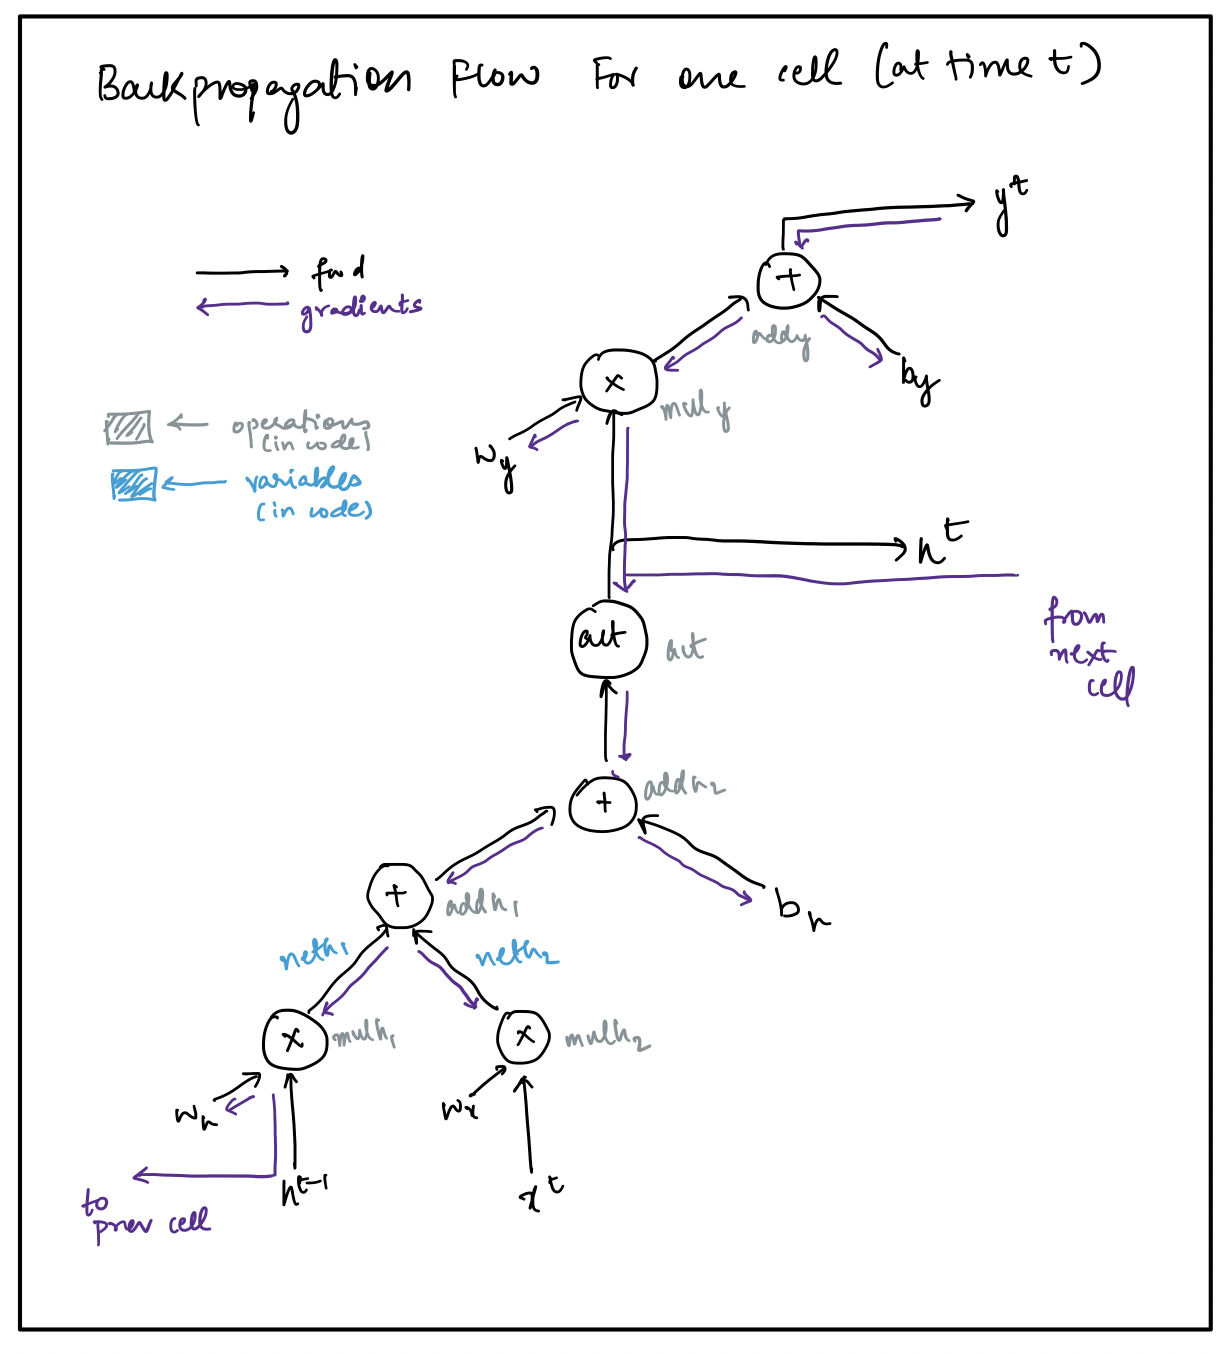

In [4]:
class RNNLayer():
    def forward(self, x, h_prev, weights):
        Wx, Wh, Wy, bh, by = weights.Wx, weights.Wh, weights.Wy, weights.bh, weights.by
        self.mulh1, self.mulh2, self.muly = Multiply(), Multiply(), Multiply() #multiplication layers for hidden states and output
        self.addh1, self.addh2, self.addy = Add(), Add(), Add() #addition layers for hidden states and output
        self.activation = Sigmoid() #activation 
        
        self.neth1 = self.mulh1(Wh, h_prev)
        self.neth2 = self.mulh2(Wx, x)
        self.h = self.activation(self.addh2(self.addh1(self.neth1, self.neth2), bh))
        self.y = self.addy(self.muly(Wy, self.h), by)
        return self.y, self.h
    
    def backward(self, x, h_prev, weights, dy, dh_next):
        """Assumes that self.forward has been called and the forward pass has been completed just before calling this"""
        Wx, Wh, Wy, bh, by = weights.Wx, weights.Wh, weights.Wy, weights.bh, weights.by
        #dWy
        # print("fsdf", dy.shape, self.addy.o.shape)
        daddy = self.addy.backward(dy); dby = daddy[1]
        dmuly = self.muly.backward(daddy[0]); dWy = dmuly[0]; dh = dmuly[1]
        dact = self.activation.backward(dh) + dh_next
        daddh2 = self.addh2.backward(dact); dbh = daddh2[1]
        daddh1 = self.addh1.backward(daddh2[0])
        dmulh1 = self.mulh1.backward(daddh1[0]); dWh = dmulh1[0]; dh_prev = dmulh1[1]
        dmulh2 = self.mulh2.backward(daddh1[1]); dWx = dmulh2[0]; dx = dmulh2[1]
        return Gradient(dWx, dWh, dWy, dbh, dby), dx, dh_prev

        

In [5]:
from tqdm import tqdm
import os
class RNN():
    def __init__(self, input_size, hidden_size, output_size, loss:Loss):
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.Wx = np.random.randn(hidden_size, input_size)
        self.Wh = np.random.randn(hidden_size, hidden_size)
        self.Wy = np.random.randn(output_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.weights = Weights(self.Wx, self.Wh, self.Wy, self.bh, self.by)
        self.loss = loss
        self.epochs_done = 0

    def forward(self, x):
        """Forward Propagation for RNN
        Input: x - input sequence of shape (batch_size, input_size, T)
        """
        T = x.shape[2]
        batch_size = x.shape[0]
        self.h_init = np.zeros((batch_size, self.hidden_size, 1))
        h = np.zeros((batch_size, self.hidden_size, T))
        y = np.zeros((batch_size, self.output_size, T))
        layers = []
        for t in range(0, T):
            layer = RNNLayer()
            if t == 0:
                y[:, :, [t]], h[:, :, [t]] = layer.forward(x[:, :, [t]], self.h_init, self.weights)
            else:
                y[:, :, [t]], h[:, :, [t]] = layer.forward(x[:, :, [t]], h[:, :, [t-1]], self.weights)
            layers.append(layer)
        # print("Hidden:", h[0], "Input Was", x[0])
        return y, h, layers

    def backward(self, x, y, y_hat, h, layers):
        """
        x - input sequence of shape (batch_size, input_size, T)
        y - ground_truth output of shape (batch_size, output_size, 1)
        y_hat - predicted output of shape (batch_size, output_size, sequence_length)
        """
        T = x.shape[2]
        y_hat = y_hat[:, :, [T-1]]
        dh_prev = np.zeros((self.hidden_size, 1))
        total_loss = self.loss(y, y_hat)
        Grad = Gradient(np.zeros_like(self.Wx), np.zeros_like(self.Wh), np.zeros_like(self.Wy), np.zeros_like(self.bh), np.zeros_like(self.by))
        for t in reversed(range(T)):
            grad = None
            if t == T - 1:
                dy = self.loss.backward(y, y_hat)
                # print("dy and y_hat shape T-1", dy.shape, y_hat.shape)
                grad, dx, dh_prev = layers[t].backward(x[:, :, [t]], h[:, :, [t-1]], self.weights, dy, dh_prev)
            elif t == 0:
                dy = np.zeros_like(y)
                grad, dx, dh_prev  = layers[t].backward(x[:, :, [t]], self.h_init, self.weights, dy, dh_prev)
            else:
                dy = np.zeros_like(y)
                grad, dx, dh_prev = layers[t].backward(x[:, :, [t]], h[:, :, [t-1]], self.weights, dy, dh_prev)
            Grad += grad
        return Grad, total_loss
    
    def train(self, X, Y, alpha, epochs, batch_size):
        """
        X - input sequence of shape (batch_size, input_size, T)
        Y - output sequence of shape (batch_size, output_size, 1)
        """
        if self.epochs_done > 0:
            print("Resuming Training from epoch", self.epochs_done)
        
        try:
            pbar = tqdm(range(self.epochs_done, epochs))
            for i in pbar:
                epoch_loss = 0
                n_batches = 0
                for j in range(0, X.shape[0], batch_size):
                    x = X[j:j+batch_size, :, :]
                    y = Y[j:j+batch_size, :, :]
                    y_hat, h, layers = self.forward(x)
                    Grad, total_loss = self.backward(x, y, y_hat, h, layers)
                    epoch_loss += np.mean(total_loss)
                    self.weights.update(Grad, alpha)
                    n_batches += 1
                self.avg_loss = epoch_loss/n_batches
                pbar.set_description(f"Epoch: {i+1}, Loss: {self.avg_loss}")
                #shuffle
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                X = X[indices]
                Y = Y[indices]
                self.epochs_done += 1
            return self.weights
        except KeyboardInterrupt:
            self.save("models")
            print("Training Interrupted. Model Saved.")
            return self.weights
    
    def save(self, folder):
        model_folder = folder+f"/{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        os.mkdir(model_folder)
        fpath = model_folder+"/weights.npz"
        self.weights.save(fpath)
        #save parameters as numpy array
        np.savez(model_folder+"/params.npz", input_size=self.input_size, hidden_size=self.hidden_size, output_size=self.output_size, epochs_done=self.epochs_done)
    
    def load(self, model_folder):
        fpath = model_folder+"/weights.npz"
        params_path = model_folder+"/params.npz"
        self.weights.load(fpath)
        with np.load(params_path) as data:
            self.input_size = data['input_size']
            self.hidden_size = data['hidden_size']
            self.output_size = data['output_size']
            self.epochs_done = data['epochs_done']

            

# Data

## Preproc

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv('GOOGL.csv')

#normalize and shift each column except date
dates = data['Date']
dates = dates.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
data = data.drop('Date', axis=1)
mean, std = data.mean(), data.std()
print("Means: \n", mean, "\n----------\nStds:\n", std)
data = (data - data.mean()) / data.std()
raw_data = data.values

target_indices = np.array([0,1,2,5]) #indices that have to be predicted
input_indices = np.array([0,1,2,3,4,5]) #indices that are used to predict



Means: 
 Open         6.930873e+02
High         6.997356e+02
Low          6.860788e+02
Close        6.930974e+02
Adj Close    6.930974e+02
Volume       6.444992e+06
dtype: float64 
----------
Stds:
 Open         6.451188e+02
High         6.513312e+02
Low          6.385795e+02
Close        6.451878e+02
Adj Close    6.451878e+02
Volume       7.690351e+06
dtype: float64


## Visualize

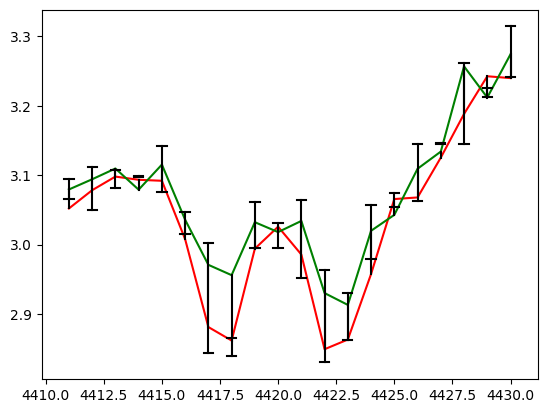

In [17]:
window = 10
visual_window = 20
offset_from_end = 0
x_vals = np.arange(len(data)-visual_window-offset_from_end, len(data)-offset_from_end)
max_len = len(data)


plt.plot(np.arange(len(data.Low))[x_vals], data.Low[x_vals], color='red')
# plt.plot(np.arange(len(data.Close))[x_vals], data.Close[x_vals], color='blue')
# plt.plot(np.arange(len(data.Open))[x_vals], data.Open[x_vals], color='yellow')
plt.plot(np.arange(len(data.High))[x_vals], data.High[x_vals], color='green')

#candlesticks
for i in x_vals:
    plt.plot([i, i], [data.Low[i], data.High[i]], color='black')
    plt.plot([i, i], [data.Open[i], data.Close[i]], color='black')
    plt.plot([i-0.2, i+0.2], [data.Open[i], data.Open[i]], color='black')
    plt.plot([i-0.2, i+0.2], [data.Close[i], data.Close[i]], color='black')
plt.show()

## Prepare Data

In [18]:
def create_dataset(data, window):
    global target_indices, input_indices
    X, Y = [], []
    for i in range(window, data.shape[0]):
        X.append(data[i-window:i, input_indices].T)
        Y.append(data[i, target_indices].reshape(-1, 1))
    return np.array(X), np.array(Y)

X, Y = create_dataset(raw_data, window)
print(X.shape, Y.shape)

(4421, 6, 10) (4421, 4, 1)


In [21]:
if not os.path.exists("models"):
    os.mkdir("models")
    
hidden_size = 32
rnn = RNN(len(input_indices), hidden_size, len(target_indices), MeanSquared_1Day())
# rnn.load("models/2024-03-19 23:39:20")
rnn.train(X, Y, 0.001, 501, 32)

Resuming Training from epoch 500


Epoch: 501, Loss: 0.4880313158206225: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


In [ ]:
rnn.save("models")

# Signal Prediction

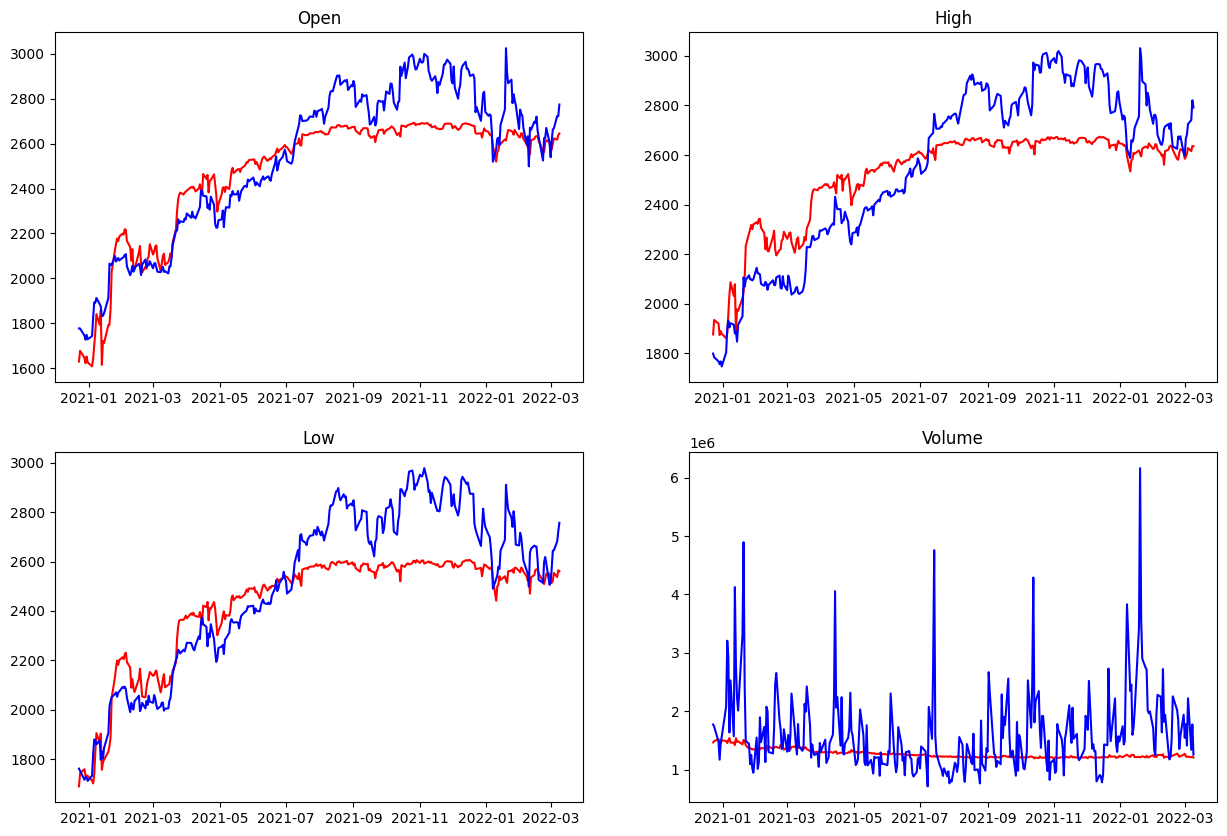

In [22]:
#predict signal and plot predicted and actual signals
#convert dates array to date objects 
startdate = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d') - datetime.timedelta(days=window)
indices = dates > startdate
predict_dates = dates[indices].values
predict_data = raw_data[indices]
predictions = {"date":[],"pred":[],"target":[] }
for i in range(0, len(predict_dates)-window-1):
    x = predict_data[i:i+window, input_indices].T

    y_target = predict_data[i+window, target_indices]

    #reshape x, y as 1 batch
    x = x.reshape(1, len(input_indices), window)
    
    y_hat, h, layers = rnn.forward(x)
    y_pred = y_hat[0, :, window-1]
    #adjust for normalization
    y_pred = y_pred*std[target_indices].values + mean[target_indices].values
    y_target = y_target*std[target_indices].values + mean[target_indices].values

    # print(f"Predicted: {y_pred}, Actual: {y_target}")
    # print(predict_dates.shape, i+window)
    predictions["date"].append(predict_dates[i+window])
    predictions["pred"].append(y_pred)
    predictions["target"].append(y_target)

predictions["pred"] = np.array(predictions["pred"])
predictions["target"] = np.array(predictions["target"])

#now we plot all variables on 4 subfigures to see how they are predicted
# add subplot titles
x_vals = predict_dates[np.arange(len(predictions["date"]))]
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(x_vals, predictions["pred"][:,0], color='red')
plt.plot(x_vals, predictions["target"][:,0], color='blue')
plt.title(data.columns[target_indices[0]])
plt.subplot(2,2,2)
plt.plot(x_vals, predictions["pred"][:,1], color='red')
plt.plot(x_vals, predictions["target"][:,1], color='blue')
plt.title(data.columns[target_indices[1]])
plt.subplot(2,2,3)
plt.plot(x_vals, predictions["pred"][:,2], color='red')
plt.plot(x_vals, predictions["target"][:,2], color='blue')
plt.title(data.columns[target_indices[2]])
plt.subplot(2,2,4)
plt.plot(x_vals, predictions["pred"][:,3], color='red')
plt.plot(x_vals, predictions["target"][:,3], color='blue')
plt.title(data.columns[target_indices[3]])
plt.show()

## Observations

We see that the model somewhat follows trends for open, high and low price values. But is not quite able to catch the trend for Volume at the current training level.

These shortcoming maybe reduced by using LSTMs or GRUs and increasing the window size for prediction since currently it is only looking at the previous 10 days.